## Bank Churn Modelling using ANN

Import Dataset and libraries

In [1]:
import pandas as pd

In [2]:
bank = pd.read_csv("../data/Churn_Modelling.csv")

Show 5 first rows

In [3]:
bank.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Redundant columns

In [4]:
custom = ["RowNumber", "CustomerId", "Surname"]

In [5]:
bank.drop(custom, axis=1, inplace=True)

EDA

In [6]:
bank.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Checking for missing data

In [7]:
bank.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Data Preprocessing

In [8]:
from sklearn.model_selection import train_test_split

Data Shuffle

In [9]:
bank = bank.sample(frac=1, random_state=225)

In [10]:
X = bank.drop("Exited", axis=1)
y = bank["Exited"]

Data splitting

In [11]:
X_full, X_test, y_full, y_test = train_test_split(X, y, test_size=0.2, random_state=51, stratify=y) # get testing data

X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.125, random_state=51, stratify=y_full) # get testing and training data

In [12]:
X_train.shape, X_test.shape, X_val.shape

((7000, 10), (2000, 10), (1000, 10))

In [13]:
bank = X_train # renaming to bank for personal preferences

In [14]:
numerical = [column for column in bank if bank[column].dtype != "O"]

feature scaling

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()

In [17]:
scaler.fit(X_train[numerical])

StandardScaler()

In [18]:
bank[numerical] = scaler.transform(bank[numerical])

Feature Encoding

In [19]:
from feature_engine.encoding import OneHotEncoder

In [20]:
encoder = OneHotEncoder()

In [21]:
encoder.fit(bank)

OneHotEncoder()

In [22]:
bank = encoder.transform(bank)

In [23]:
bank.shape

(7000, 13)

Imbalanced Data Handling

In [24]:
from imblearn.over_sampling import SMOTE

In [25]:
smote = SMOTE(sampling_strategy='minority')

In [26]:
X_train, y_train = smote.fit_resample(bank, y_train)

y_train.value_counts()

0    5574
1    5574
Name: Exited, dtype: int64

Data Processing for Validation

In [27]:
X_val[numerical] = scaler.transform(X_val[numerical])
X_val = encoder.transform(X_val)


Data Processing for Testing

In [28]:
X_test[numerical] = scaler.transform(X_test[numerical])
X_test = encoder.transform(X_test)


Deep Learning

In [30]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [31]:
i = layers.Input(shape=(13,))

x = layers.Dense(32, activation="relu")(i)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(i, x)

In [33]:
# model = keras.Sequential([
#     layers.Dense(32, activation="relu", input_shape=(13,)),
#     layers.Dense(64, activation="relu"),
#     layers.Dense(32, activation="relu"),
#     layers.Dense(1, activation="sigmoid")
# ])

In [32]:
model.compile(
    optimizer="rmsprop", 
    loss="binary_crossentropy", 
    metrics=["accuracy", keras.metrics.AUC()]
)

In [33]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
349/349 [==============================] - 3s 4ms/step - loss: 0.5244 - accuracy: 0.7407 - auc: 0.8176 - val_loss: 0.4395 - val_accuracy: 0.7920 - val_auc: 0.8290
Epoch 2/10
349/349 [==============================] - 2s 4ms/step - loss: 0.4326 - accuracy: 0.8017 - auc: 0.8812 - val_loss: 0.5146 - val_accuracy: 0.7410 - val_auc: 0.8503
Epoch 3/10
349/349 [==============================] - 1s 3ms/step - loss: 0.4098 - accuracy: 0.8119 - auc: 0.8941 - val_loss: 0.4520 - val_accuracy: 0.7900 - val_auc: 0.8511
Epoch 4/10
349/349 [==============================] - 1s 3ms/step - loss: 0.3952 - accuracy: 0.8185 - auc: 0.9020 - val_loss: 0.3952 - val_accuracy: 0.8270 - val_auc: 0.8522
Epoch 5/10
349/349 [==============================] - 1s 3ms/step - loss: 0.3846 - accuracy: 0.8268 - auc: 0.9073 - val_loss: 0.4727 - val_accuracy: 0.7770 - val_auc: 0.8499
Epoch 6/10
349/349 [==============================] - 1s 2ms/step - loss: 0.3776 - accuracy: 0.8314 - auc: 0.9108 - val_loss: 0.44

Test Prediction

In [34]:
import numpy as np
import seaborn as sns

In [35]:
model.evaluate(X_val, y_val)

32/32 [==============================] - 0s 3ms/step - loss: 0.4211 - accuracy: 0.8100 - auc: 0.8476


[0.4211341142654419, 0.8100000023841858, 0.8476080894470215]

In [36]:
predictions = model.predict(X_val)

32/32 [==============================] - 0s 2ms/step


In [37]:
predictions = np.round(predictions)

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

<Axes: >

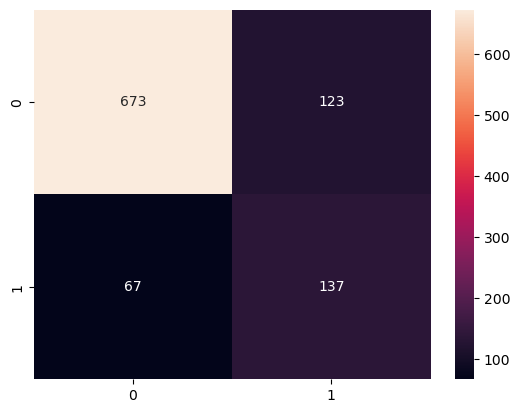

In [39]:
sns.heatmap(confusion_matrix(y_val, predictions), annot=True, fmt="d")

In [40]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       796
           1       0.53      0.67      0.59       204

    accuracy                           0.81      1000
   macro avg       0.72      0.76      0.73      1000
weighted avg       0.83      0.81      0.82      1000



Regularization 

In [42]:
i = layers.Input(shape=(13,))

x = layers.Dense(32, activation="relu")(i)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(i, x)

In [43]:
# model = keras.Sequential([
#     layers.Dense(32, activation="relu", input_shape=(13,)),
#     # layers.Dropout(0.2),
#     layers.Dense(64, activation="relu"),
#     layers.Dropout(0.2),
#     layers.Dense(32, activation="relu"),
#     # layers.Dropout(0.2),
#     layers.Dense(1, activation="sigmoid")
# ])

In [44]:
model.compile(
    optimizer="adam", 
    loss="binary_crossentropy", 
    metrics=["accuracy", keras.metrics.AUC()]
)

In [45]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
349/349 [==============================] - 5s 8ms/step - loss: 0.5372 - accuracy: 0.7282 - auc_1: 0.8044 - val_loss: 0.4875 - val_accuracy: 0.7580 - val_auc_1: 0.8381
Epoch 2/10
349/349 [==============================] - 2s 5ms/step - loss: 0.4484 - accuracy: 0.7934 - auc_1: 0.8715 - val_loss: 0.4605 - val_accuracy: 0.7850 - val_auc_1: 0.8472
Epoch 3/10
349/349 [==============================] - 1s 4ms/step - loss: 0.4294 - accuracy: 0.8062 - auc_1: 0.8837 - val_loss: 0.4239 - val_accuracy: 0.7970 - val_auc_1: 0.8453
Epoch 4/10
349/349 [==============================] - 1s 3ms/step - loss: 0.4091 - accuracy: 0.8125 - auc_1: 0.8949 - val_loss: 0.4450 - val_accuracy: 0.7860 - val_auc_1: 0.8484
Epoch 5/10
349/349 [==============================] - 1s 4ms/step - loss: 0.3960 - accuracy: 0.8189 - auc_1: 0.9016 - val_loss: 0.4337 - val_accuracy: 0.8040 - val_auc_1: 0.8502
Epoch 6/10
349/349 [==============================] - 1s 3ms/step - loss: 0.3869 - accuracy: 0.8271 - auc_1: 0

Test Prediction

In [46]:
import numpy as np
import seaborn as sns

In [47]:
model.evaluate(X_val, y_val)

32/32 [==============================] - 0s 4ms/step - loss: 0.4375 - accuracy: 0.7990 - auc_1: 0.8491


[0.4375333786010742, 0.7990000247955322, 0.8490707278251648]

In [48]:
predictions = model.predict(X_val)

32/32 [==============================] - 0s 1ms/step


In [49]:
predictions = np.round(predictions)

In [50]:
from sklearn.metrics import confusion_matrix, classification_report

<Axes: >

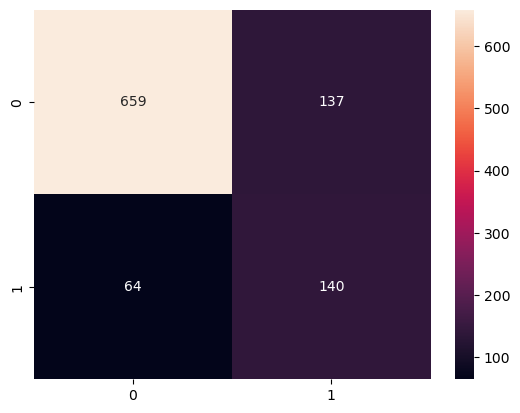

In [51]:
sns.heatmap(confusion_matrix(y_val, predictions), annot=True, fmt="d")

In [52]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       796
           1       0.51      0.69      0.58       204

    accuracy                           0.80      1000
   macro avg       0.71      0.76      0.72      1000
weighted avg       0.83      0.80      0.81      1000

